In [ ]:
using PyPlot

In [ ]:
push!(LOAD_PATH, ".");
using quantum
names(quantum)

In [3]:
hadamard = [1 1; 1 -1]/sqrt(2)

2x2 Array{Float64,2}:
 0.707107   0.707107
 0.707107  -0.707107

In [4]:
function concat_ancilla(psi::Array{Complex{Float64},2}, n::Int64)
    psi_anc = zeros(Complex{Float64}, 2^(n+1))
    psi_anc[1:length(psi)] = psi
    return psi_anc
end

concat_ancilla (generic function with 1 method)

In [5]:
function apply_control_not!(psi::Array{Complex{Float64},1}, control_qubit::Int64, target_qubit::Int64)
    psi_i_temp = copy(psi)
    mov = max(control_qubit,target_qubit)
    for i = 0:length(psi)-1
        if testbit(i,control_qubit) & !testbit(i,target_qubit)
            psi[i+1] = psi_i_temp[i+1+2^mov]
        elseif testbit(i,control_qubit) & testbit(i,target_qubit)
            psi[i+1] = psi_i_temp[i+1-2^mov]
        end
    end
end

function apply_toffoli!(psi::Array{Complex{Float64},1}, control_qubit1::Int64, control_qubit2::Int64, target_qubit::Int64)
    psi_i_temp = copy(psi)
    mov = target_qubit
    for i = 0:length(psi)-1
        if testbit(i,control_qubit1) & testbit(i,control_qubit2) & !testbit(i,target_qubit)
            psi[i+1] = psi_i_temp[i+1+2^mov]
        elseif testbit(i,control_qubit1) & testbit(i,control_qubit2) & testbit(i,target_qubit)
            psi[i+1] = psi_i_temp[i+1-2^mov]
        end
    end
end

apply_toffoli! (generic function with 1 method)

In [6]:
function encoder(psi::Array{Complex{Float64},2})
    psi_encode = concat_ancilla(psi, 8)
    
    apply_control_not!(psi_encode, 0, 3)
    apply_control_not!(psi_encode, 0, 6)
    
    for i in 0:2
        apply_unitary!(psi_encode, hadamard, 3*i)
    end
        
    for i in 0:2
        apply_control_not!(psi_encode, 3*i, 3*i+1)
    end
    
    for i in 0:2
        apply_control_not!(psi_encode, 3*i, 3*i+2)
    end
    

    return psi_encode
end

encoder (generic function with 1 method)

In [7]:
function error_generator(Err, psi::Array{Complex{Float64},1}, p::Float64)
    n = Int(log2(length(psi)))
    psi_err = copy(psi)
    for i=0:n-1
        if rand()< p
            err = rand(Err)
            apply_unitary!(psi_err, err, n-1-i)
        end
    end
    return psi_err
end

function error_generator(Err, psi::Array{Complex{Float64},2}, p::Float64)
    n = Int(log2(length(psi)))
    psi_err = copy(psi)
    for i=0:n-1
        if rand()< p
            err = rand(Err)
            apply_unitary!(psi_err, err, n-1-i)
        end
    end
    return psi_err
end

error_generator (generic function with 2 methods)

In [8]:
stabilizerGroupeOp = Array[ sigma_z, sigma_z, sigma_z, sigma_z,
                            sigma_z, sigma_z, sigma_x, sigma_x]
stabilizerGroupeIdx = Array[[1 0],[2 1],[4 3],[5 4],[7 6],[8 7],[5 4 3 2 1 0],[8 7 6 5 4 3]]

stabilizerCorrectionBitFlipEv = Array[
    [-1; 1; 1; 1; 1; 1],
    [-1; -1; 1; 1; 1; 1],
    [1; -1; 1; 1; 1; 1],
    [1; 1; -1; 1; 1; 1],
    [1; 1; -1; -1; 1; 1],
    [1; 1; 1; -1; 1; 1],
    [1; 1; 1; 1; -1; 1],
    [1; 1; 1; 1; -1; -1],
    [1; 1; 1; 1; 1; -1]
]
stabilizerCorrectionBitFlipIdx = [0;1;2;3;4;5;6;7;8]

stabilizerCorrectionPhaseFlipEv = Array[[-1;1], [-1;-1], [1;-1]]
stabilizerCorrectionPhaseFlipIdx = Array[[0 1 2], [3 4 5], [6 7 8]];

In [9]:
function error_correction_mesurement(psi::Array{Complex{Float64},1})
    results = zeros(Int64,length(stabilizerGroupeIdx))
    
    for i in 1:8
        psi_test = copy(psi)
        for j in 1:length(stabilizerGroupeIdx[i])
            apply_unitary!(psi_test, stabilizerGroupeOp[i], stabilizerGroupeIdx[i][j])
        end
        if psi_test == psi
            results[i] = 1
        elseif psi_test == -psi
            results[i] = -1
        end 
    end
    
    psi_corr = copy(psi)
    for i in 1:9
        if results[1:6] == stabilizerCorrectionBitFlipEv[i]
            apply_unitary!(psi_corr, sigma_x, stabilizerCorrectionBitFlipIdx[i])
        end
    end
    for i in 1:3
        if results[7:8] == stabilizerCorrectionPhaseFlipEv[i]
            for j in 1:3  
                apply_unitary!(psi_corr, sigma_z, stabilizerCorrectionPhaseFlipIdx[i][j])
            end
        end
    end
    
    for i in 0:2
        apply_control_not!(psi_corr, 3*i, 3*i+1)
    end
    
    for i in 0:2
        apply_control_not!(psi_corr, 3*i, 3*i+2)
    end
    
    for i in 0:2
        apply_toffoli!(psi_corr, 3*i+2, 3*i+1, 3*i)
    end
    
    for i in 0:2
        apply_unitary!(psi_corr, hadamard, 3*i)
    end
    
    apply_control_not!(psi_corr, 0, 6)
    apply_control_not!(psi_corr, 0, 3)
    apply_toffoli!(psi_corr, 6, 3, 0)
    
    return psi_corr
end

error_correction_mesurement (generic function with 1 method)

In [10]:
for i in 0:8
    psi = random_state(2)
    psi_enc = encoder(psi)
    apply_unitary!(psi_enc, sigma_z, i)
    psi_corr = error_correction_mesurement(psi_enc)
    
    @show norm(psi_corr[1:2]-psi)
end

norm(psi_corr[1:2] - psi) = 5.4672143489065705e-16
norm(psi_corr[1:2] - psi) = 6.425880329391634e-16
norm(psi_corr[1:2] - psi) = 4.0221650305342743e-16
norm(psi_corr[1:2] - psi) = 6.684427777288335e-16
norm(psi_corr[1:2] - psi) = 4.1284960951691644e-16
norm(psi_corr[1:2] - psi) = 6.48628858709965e-16
norm(psi_corr[1:2] - psi) = 5.661048867003676e-16
norm(psi_corr[1:2] - psi) = 6.304854800243424e-16
norm(psi_corr[1:2] - psi) = 4.585973723508303e-16


In [16]:
for i in 0:8
    psi = random_state(2)
    psi_enc = encoder(psi)
    apply_unitary!(psi_enc, sigma_x, i)
    psi_corr = error_correction_mesurement(psi_enc)
    
    @show norm(psi_corr[1:2]-psi)
end

norm(psi_corr[1:2] - psi) = 4.46265832561482e-16
norm(psi_corr[1:2] - psi) = 5.579044384146987e-16
norm(psi_corr[1:2] - psi) = 6.080941944488118e-16
norm(psi_corr[1:2] - psi) = 5.273559366969494e-16
norm(psi_corr[1:2] - psi) = 5.73036696484635e-16
norm(psi_corr[1:2] - psi) = 5.224024053540252e-16
norm(psi_corr[1:2] - psi) = 4.918300529807393e-16
norm(psi_corr[1:2] - psi) = 5.959374814064025e-16
norm(psi_corr[1:2] - psi) = 5.20740757162067e-16


In [21]:
for i in 0:8
    psi = random_state(2)
    psi_enc = encoder(psi)
    apply_unitary!(psi_enc, sigma_x, i)
    apply_unitary!(psi_enc, sigma_z, i)
    psi_corr = error_correction_mesurement(psi_enc)
    
    @show norm(psi_corr[1:2]-psi)
end

norm(psi_corr[1:2] - psi) = 1.9999999999999996
norm(psi_corr[1:2] - psi) = 1.9999999999999996
norm(psi_corr[1:2] - psi) = 1.9999999999999991
norm(psi_corr[1:2] - psi) = 1.9999999999999993
norm(psi_corr[1:2] - psi) = 1.9999999999999993
norm(psi_corr[1:2] - psi) = 1.9999999999999996
norm(psi_corr[1:2] - psi) = 1.9999999999999996
norm(psi_corr[1:2] - psi) = 1.9999999999999996
norm(psi_corr[1:2] - psi) = 1.9999999999999996


In [22]:
function count_coincidence_error_correction(p::Array{Float64,1}, case::AbstractString, N=10000)
    coincidences = zeros(Float64, length(p))
    n = 1
    @sync @parallel for j in 1:length(p)
        for i=1:N
            psi = random_state(2)
            if case == "correction"
                psi_enc = encoder(psi)
                psi_enc_err = error_generator(Array[sigma_x], psi_enc, p[j])
                psi_enc_err_err = error_generator(Array[sigma_z], psi_enc_err, p[j])
                psi_enc_corrected = error_correction_mesurement(psi_enc_err_err)
                
                if norm(psi - psi_enc_corrected[1:2]) < 1e-6
                    coincidences[j] += 1.
                elseif norm(psi - psi_enc_corrected[1:2] - 2) < 1e-6
                    coincidences[j] += 1.
                end
            elseif case == "no_encoded"
                psi_err = error_generator(Array[sigma_x], psi, p[j])
                psi_enc_err = error_generator(Array[sigma_z], psi_err, p[j])
                if psi == psi_enc_err
                    coincidences[j] += 1.
                end
            end
        end
    end
    return coincidences/N
end

count_coincidence_error_correction (generic function with 2 methods)

In [25]:
p = collect(0:0.01:1);
coincidencias_qec = count_coincidence_error_correction(p, "correction", 5000);
coincidencias_e = count_coincidence_error_correction(p, "no_encoded", 10000);

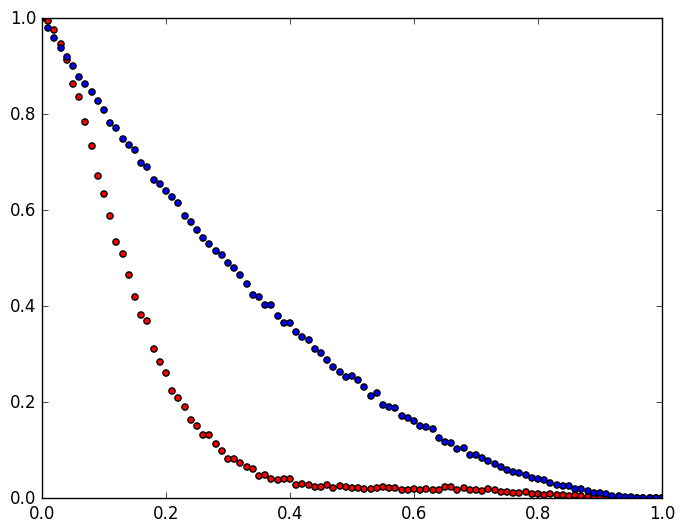

In [26]:
scatter(p, coincidencias_qec, c = "red")
scatter(p, coincidencias_e, c = "blue")
xlim([0,1]); ylim([0,1]);

In [27]:
p2 = 0.1*collect(0:0.01:1);
coincidencias_qec = count_coincidence_error_correction(p2, "correction", 5000);
coincidencias_e = count_coincidence_error_correction(p2, "no_encoded", 10000);

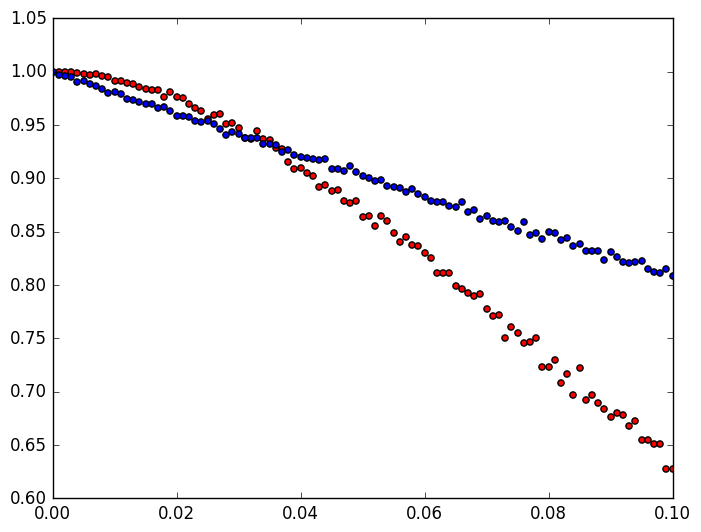

In [30]:
scatter(p2, coincidencias_qec, c = "red")
scatter(p2, coincidencias_e, c = "blue")
xlim([0,0.1]);